<a href="https://colab.research.google.com/github/IanEdington/learn/blob/master/machine-learning/ggl-mlcc/Multi_class_classification_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Yann LeCun and Corinna Cortes hold the copyright of MNIST dataset,
# which is a derivative work from original NIST datasets. 
# MNIST dataset is made available under the terms of the 
# Creative Commons Attribution-Share Alike 3.0 license.

# Multi-Class Classification

This Colab explore multi-class classification problems through the classic MNIST dataset.

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Understand the classic MNIST problem.
  * Create a deep neural network that performs multi-class classification.
  * Tune the deep neural network.

This exercise introduces image classification with machine learning.

## The Dataset
  
This MNIST dataset contains a lot of examples:

* The MNIST training set contains 60,000 examples.
* The MNIST test set contains 10,000 examples.

Each example contains a pixel map showing how a person wrote a digit. For example, the following images shows how a person wrote the digit `1` and how that digit might be represented in a 14x14 pixel map (after the input data is normalized). 

![Two images. The first image shows a somewhat fuzzy digit one. The second image shows a 14x14 floating-point array in which most of the cells contain 0 but a few cells contain values between 0.0 and 1.0. The pattern of nonzero values corresponds to the image of the fuzzy digit in the first image.](https://www.tensorflow.org/images/MNIST-Matrix.png)

Each example in the MNIST dataset consists of:

* A label specified by a [rater](https://developers.google.com/machine-learning/glossary/#rater).  Each label must be an integer from 0 to 9.  For example, in the preceding image, the rater would almost certainly assign the label `1` to the example.
* A 28x28 pixel map, where each pixel is an integer between 0 and 255. The pixel values are on a gray scale in which 0 represents white, 255 represents black, and values between 0 and 255 represent various shades of gray.  

This is a multi-class classification problem with 10 output classes, one for each digit.

## Use the right version of TensorFlow

The following hidden code cell ensures that the Colab will run on TensorFlow 2.X.

In [0]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [0]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

## Load the dataset

`tf.keras` provides a set of convenience functions for loading well-known datasets. Each of these convenience functions does the following:

* Loads both the training set and the test set.
* Separates each set into features and labels.

The relevant convenience function for MNIST is called `mnist.load_data()`:

In [0]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()


Notice that `mnist.load_data()` returned four separate values:

* `x_train` contains the training set's features.
* `y_train` contains the training set's labels.
* `x_test` contains the test set's features.
* `y_test` contains the test set's labels.

**Note:** The MNIST .csv training set is already shuffled.

## View the dataset

The .csv file for the California Housing Dataset contains column names (for example, `latitude`, `longitude`, `population`). By contrast, the .csv file for MNIST does not contain column names. Instead of column names, you use ordinal numbers to access different subsets of the MNIST dataset. In fact, it is probably best to think of `x_train` and `x_test` as three-dimensional NumPy arrays:  



In [0]:
# Output example #2917 of the training set.
x_train[2917]

Alternatively, you can call `matplotlib.pyplot.imshow` to interpret the preceding numeric array as an image. 

In [0]:
# Use false colors to visualize the array.
plt.imshow(x_train[2917])

In [0]:
# Output row #10 of example #2917.
x_train[2917][10]

In [0]:
# Output pixel #16 of row #10 of example #2900.
x_train[2917][10][16]

## Task 1: Normalize feature values

Complete the following code cell to map each feature value from its current representation (an integer between 0 and 255) to a floating-point value between 0 and 1.0. Store the floating-point values in `x_train_normalized` and `x_test_normalized`.

In [0]:
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
print(x_train_normalized[2900][10]) # Output a normalized row

In [0]:
#@title Double-click to see a solution to Task 1. 

x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
print(x_train_normalized[2900][12]) # Output a normalized row

## Define a plotting function

The following function plots an accuracy curve:

In [0]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

## Create a deep neural net model

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.
* Any [regularization](https://developers.google.com/machine-learning/glossary/#regularization) layers.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.  The activation function of the output layer is [softmax](https://developers.google.com/machine-learning/glossary/#softmax), which will yield 10 different outputs for each example. Each of the 10 outputs provides the probability that the input example is a certain digit.

**Note:** Unlike several of the recent Colabs, this exercise does not define feature columns or a feature layer.  Instead, the model will train on the NumPy array.

In [0]:
def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

## Invoke the previous functions

Run the following code cell to invoke the preceding functions and actually train the model on the training set. 

**Note:** Due to several factors (for example, more examples and a more complex neural network) training MNIST might take longer than training the California Housing Dataset. Be patient.

Epoch 1/50
12/12 [==============================] - 0s 39ms/step - loss: 1.6788 - accuracy: 0.4762 - val_loss: 0.9344 - val_accuracy: 0.7875
Epoch 2/50
12/12 [==============================] - 0s 32ms/step - loss: 0.8533 - accuracy: 0.7500 - val_loss: 0.5068 - val_accuracy: 0.8696
Epoch 3/50
12/12 [==============================] - 0s 33ms/step - loss: 0.6070 - accuracy: 0.8200 - val_loss: 0.3951 - val_accuracy: 0.8975
Epoch 4/50
12/12 [==============================] - 0s 32ms/step - loss: 0.5046 - accuracy: 0.8536 - val_loss: 0.3398 - val_accuracy: 0.9090
Epoch 5/50
12/12 [==============================] - 0s 33ms/step - loss: 0.4507 - accuracy: 0.8689 - val_loss: 0.3081 - val_accuracy: 0.9172
Epoch 6/50
12/12 [==============================] - 0s 34ms/step - loss: 0.4110 - accuracy: 0.8824 - val_loss: 0.2857 - val_accuracy: 0.9238
Epoch 7/50
12/12 [==============================] - 0s 32ms/step - loss: 0.3864 - accuracy: 0.8886 - val_loss: 0.2691 - val_accuracy: 0.9280
Epoch 8/50
12

[0.13523469865322113, 0.9591000080108643]

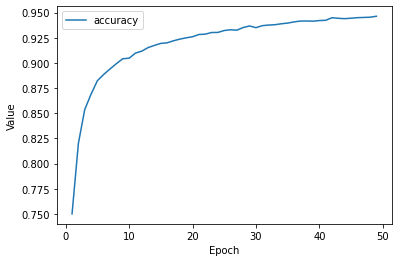

In [23]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.2

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train_normalized, y_train, 
                           epochs, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test_normalized, y=y_test, batch_size=batch_size)

In [0]:
def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))
  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist
  
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.2

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train_normalized, y_train, 
                           epochs, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test_normalized, y=y_test, batch_size=batch_size)

Epoch 1/50
12/12 [==============================] - 1s 45ms/step - loss: 1.9905 - accuracy: 0.3192 - val_loss: 1.3168 - val_accuracy: 0.6142
Epoch 2/50
12/12 [==============================] - 0s 38ms/step - loss: 1.3332 - accuracy: 0.5450 - val_loss: 0.7386 - val_accuracy: 0.7944
Epoch 3/50
12/12 [==============================] - 0s 39ms/step - loss: 0.9645 - accuracy: 0.6744 - val_loss: 0.4990 - val_accuracy: 0.8515
Epoch 4/50
12/12 [==============================] - 0s 39ms/step - loss: 0.7570 - accuracy: 0.7514 - val_loss: 0.3979 - val_accuracy: 0.8840
Epoch 5/50
12/12 [==============================] - 0s 39ms/step - loss: 0.6398 - accuracy: 0.7991 - val_loss: 0.3285 - val_accuracy: 0.9071
Epoch 6/50
12/12 [==============================] - 0s 38ms/step - loss: 0.5617 - accuracy: 0.8308 - val_loss: 0.2846 - val_accuracy: 0.9169
Epoch 7/50
12/12 [==============================] - 0s 39ms/step - loss: 0.5029 - accuracy: 0.8514 - val_loss: 0.2576 - val_accuracy: 0.9253
Epoch 8/50
12

[0.15451927483081818, 0.9567999839782715]

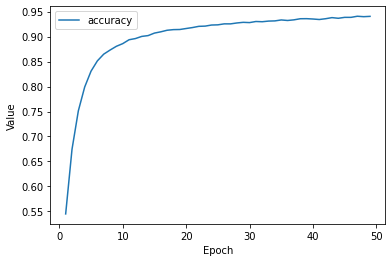

In [21]:
def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # Define the first hidden layer.
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  # Define a dropout regularization layer.
  model.add(tf.keras.layers.Dropout(rate=0.2))
  # Define the first hidden layer.
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))
  # Define the first hidden layer.
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist
  
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.2

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train_normalized, y_train, 
                           epochs, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test_normalized, y=y_test, batch_size=batch_size)

Epoch 1/100
12/12 [==============================] - 2s 138ms/step - loss: 1.4001 - accuracy: 0.5329 - val_loss: 0.4342 - val_accuracy: 0.8826
Epoch 2/100
12/12 [==============================] - 2s 134ms/step - loss: 0.5335 - accuracy: 0.8415 - val_loss: 0.2626 - val_accuracy: 0.9227
Epoch 3/100
12/12 [==============================] - 2s 133ms/step - loss: 0.3444 - accuracy: 0.9017 - val_loss: 0.1965 - val_accuracy: 0.9405
Epoch 4/100
12/12 [==============================] - 2s 132ms/step - loss: 0.2639 - accuracy: 0.9269 - val_loss: 0.1652 - val_accuracy: 0.9518
Epoch 5/100
12/12 [==============================] - 2s 128ms/step - loss: 0.2166 - accuracy: 0.9398 - val_loss: 0.1394 - val_accuracy: 0.9592
Epoch 6/100
12/12 [==============================] - 2s 130ms/step - loss: 0.1807 - accuracy: 0.9495 - val_loss: 0.1256 - val_accuracy: 0.9629
Epoch 7/100
12/12 [==============================] - 2s 129ms/step - loss: 0.1527 - accuracy: 0.9579 - val_loss: 0.1157 - val_accuracy: 0.9665

[0.11414625495672226, 0.9814000129699707]

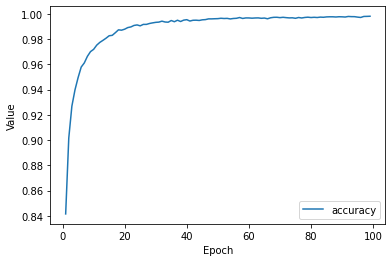

In [25]:
def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # Define the first hidden layer.
  model.add(tf.keras.layers.Dense(units=300, activation='relu'))
  # Define a dropout regularization layer.
  model.add(tf.keras.layers.Dropout(rate=0.2))
  # Define the first hidden layer.
  model.add(tf.keras.layers.Dense(units=150, activation='relu'))
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))
  # Define the first hidden layer.
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist
  
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.2

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train_normalized, y_train, 
                           epochs, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test_normalized, y=y_test, batch_size=batch_size)

## Task 2: Optimize the model

Experiment with the following:

* number of hidden layers 
* number of nodes in each layer
* dropout regularization rate

What trends did you discover?  Can you reach at least 98% accuracy against the test set? 




In [0]:

# It would take much too long to experiment 
# fully with topography and dropout regularization 
# rate. In the real world, you would
# also experiment with learning rate, batch size, 
# and number of epochs.  Since you only have a 
# few minutes, searching for trends can be helpful.
# Here is what we discovered:
#   * Adding more nodes (at least until 256 nodes) 
#     to the first hidden layer improved accuracy.
#   * Adding a second hidden layer generally 
#     improved accuracy.
#   * When the model contains a lot of nodes, 
#     the model overfits unless the dropout rate 
#     is at least 0.5. 

# We reached 98% test accuracy with the 
# following configuration:
#   * One hidden layer of 256 nodes; no second 
      hidden layer.
#   * dropout regularization rate of 0.4

# We reached 98.2% test accuracy with the 
# following configuration:
#   * First hidden layer of 256 nodes; 
#     second hidden layer of 128 nodes.
#   * dropout regularization rate of 0.2
